#Семинар 1. Классические линейные модели.
В данном ноутбуке будут приведены примеры построения моделей из лекций 1 и 2, после чего предлагается воспроизвести процедуру настройки моделей на других временных рядах.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import scipy.stats as scs
from arch import arch_model

import matplotlib as mpl
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from arch import arch_model

## Модель SARIMA
- Seasonal ARIMA = SARIMA
$$ \text{SARIMA}(p, d, q)(P, D, Q)_S $$
    - Базовые компоненты
        - p: autoregressive order
        - d: differencing order
        - q: moving average order
    - Сезонные компоненты
        - P: seasonal autoregressive order
        - D: seasonal differencing order
        - Q: seasonal moving average order
        - S: длина сезона
- Примеры моделей ARIMA и SARIMA
    - ARIMA(2, 0, 1):
$$ x_t = a_1 x_{t-1} + a_2 x_{t-2} + m_1 \epsilon_{t-1} + \epsilon_t $$
    - SARIMA(0,0,0)(2, 0, 1)_7:
$$ x_t = a_7 x_{t-7} + a_{14} x_{t-14} + m_y \epsilon_{t-7} + \epsilon_t $$

- Сезонное дифференцирование
    - Вычитание из текущего значения его значения, соответствующего прошлому сезону
$$ \Delta x_t = x_t - x_{t-S} $$

## Исследуемый временной ряд
Сгенерируем искусственный временной ряд с трендом, сезонной компонентой и шумом.

In [2]:
N = 700
trend = np.linspace(0, 2, N)**3
season = 1.5*np.sin(2*np.pi/(4*12) * np.arange(N))
wn = np.random.normal(loc=0.0, scale=0.5, size=N)
heteroskedastic = np.linspace(1, 2, N)
ts = trend + heteroskedastic*season + wn

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/88/gsb2h1td1v772jpnk7t4k9qm0000gn/T/ipykernel_31984/1342635925.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


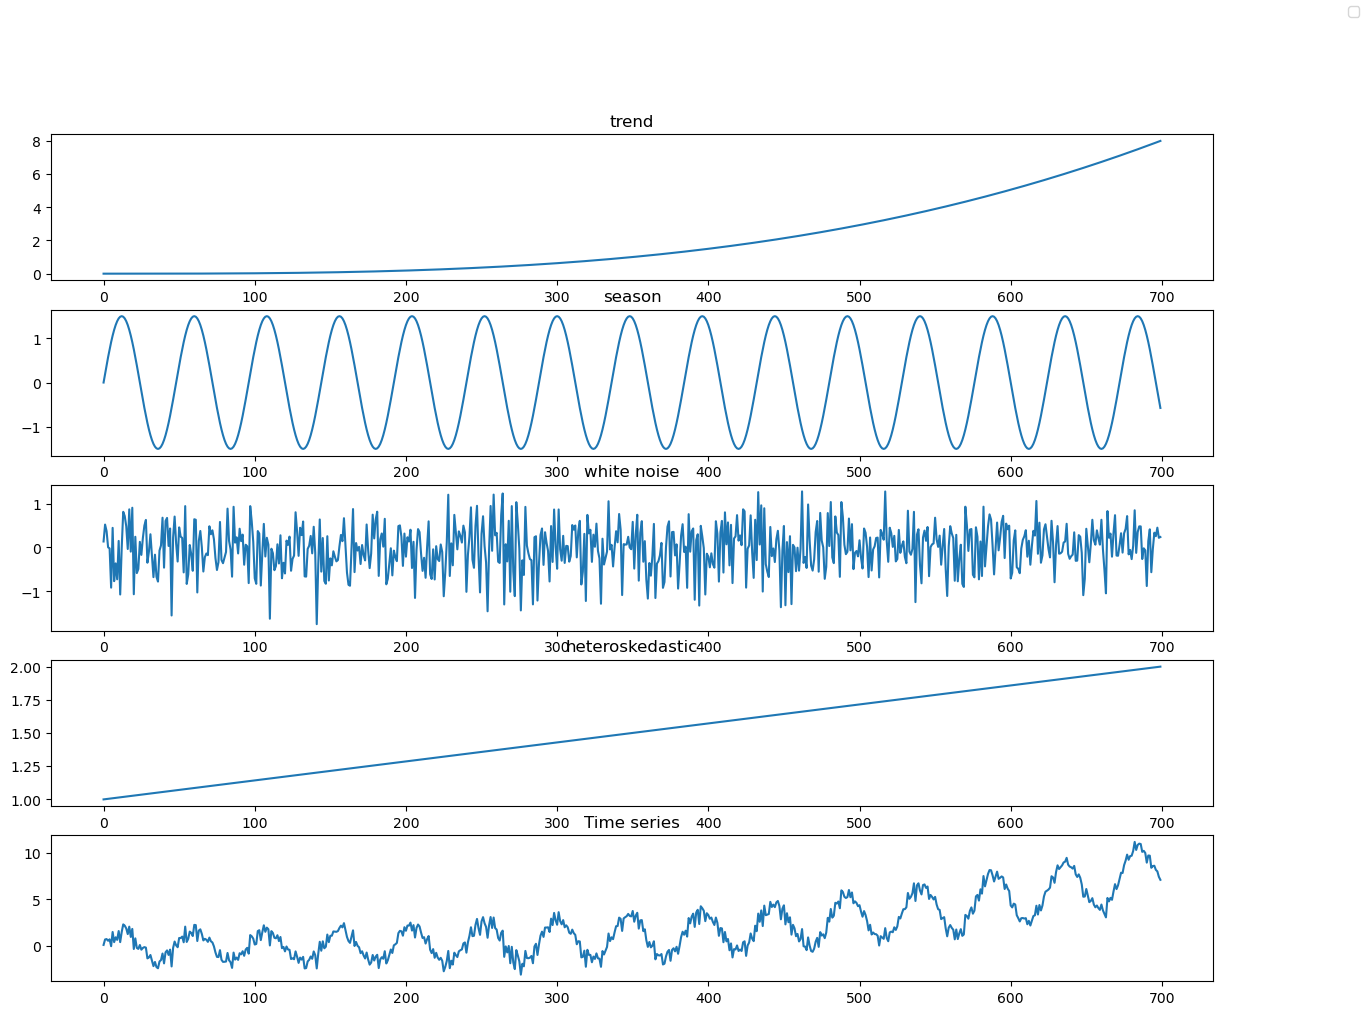

In [3]:
fig, axs = plt.subplots(5, 1, figsize = (15,11))
axs[0].plot(trend)
axs[0].set_title('trend')
axs[1].plot(season)
axs[1].set_title('season')
axs[2].plot(wn)
axs[2].set_title('white noise')
axs[3].plot(heteroskedastic)
axs[3].set_title('heteroskedastic')
axs[4].plot(ts)
axs[4].set_title('Time series')
fig.legend()
fig.show()

## Последовательность действия для построения ARIMA модели
1. Строится график ряда, идентифицируются необычные значения.
2. Если ряд сильно нестационарный подбирается порядок дифференцирования.
  - Рекомендуется сначала выбрать поряд сезонного дифференцирования, потом обычного дифференцирования.

4. Анализируются ACF/[PACF](http://www.machinelearning.ru/wiki/index.php?title=%D0%A7%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D1%8F
), чтобы выбрать начальные приближения для параметров.
  - p - последний значимый несезонный лаг (меньше сезонного периода) по [PACF](http://www.machinelearning.ru/wiki/index.php?title=%D0%A7%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D1%8F
)
  - q - последний значимый несезонный лаг (меньше сезонного периода) по ACF
  - P - последний значимый сезонный лаг по [PACF](http://www.machinelearning.ru/wiki/index.php?title=%D0%A7%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D1%8F
)
  - Q - последний значимый сезонный лаг по ACF
5. Обучаются модели-кандидаты, в окрестностях начального приближения, сравнивается их AIC/BIC.
6. Остатки полученной модели исследуются на несмещённость, стационарность и неавтокоррелированность; если предположения невыполняются,исследуются модификациимодели.

___
"Лаг" - величина сдвига в ACF/PACF; значимость лага - выход значения за пределы доверительного интервала, центрированного в нуле (см. комментарий ниже)
___

При обучении моделей SARIMAX одновременное нахождение оптимальных значений (p, q, d, P, Q, D) является возможным (см. pmdarima.auto_arima), но даже в таком случае удобно определить начальные значения параметров на основе анализа автокорреляционной функции ряда.

Конкретно, методы statsmodels.tsa.api.plot_acf и statsmodels.tsa.api.plot_pacf позволяют построить автокорреляционную (ACF) и частичную автокорреляционную (PACF) функции ряда, а также построить для их значений доверительные интервалы. Доверительные интервалы на этих графиках отображаются на фоне в виде сплошной области, симметричной относительно оси абсцисс.

По графикам этих функций определяются последние моменты времени, когда их значения существенно отличаются от нуля (т.е. не попадают в доверительный интервал). Эти значения, делённые нацело на подобранное значение сезонного периода S, и равны P и Q для PACF и ACF соответственно.

Далее осуществляется дифференцирование ряда (обычное и сезонное), порядки дифференцирования определяются вручную. Наконец, для нового преобразованного ряда вновь строим ACF и PACF и по самым последним их значениям, выходящим за пределы доверительного интервала, определяем q и p соответственно. Ниже приведен пример.

## Графики автокорреляционной функции

Нужно использовать ACF и PACF для проверки сезонности данных.
Из графика выше видно, что временной ряд не является стационарным, поэтому, вероятно, следует исключить из него тренд.
Удалить тренд можно либо с помощью вычитания тренда напрямую, либо использовать дифференцирование временного ряда.

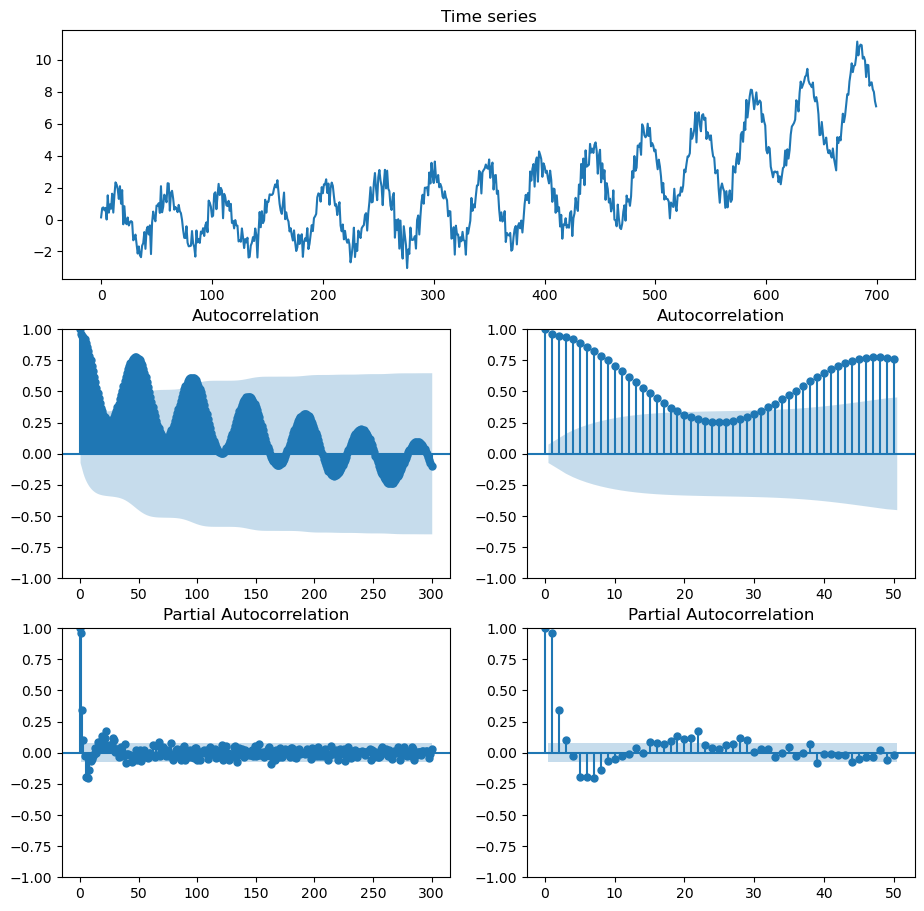

In [4]:
fig, axs = plt.subplots(3, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(ts)
axbig.set_title('Time series')

smt.graphics.plot_acf(ts, lags=300, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(ts, lags=300, ax=axs[2,0], alpha=0.05)

smt.graphics.plot_acf(ts, lags=50, ax=axs[1,1], alpha=0.05)
smt.graphics.plot_pacf(ts, lags=50, ax=axs[2,1], alpha=0.05)
plt.show()

Выводы:
1. Есть тренд - используем дифференцирование d = 1, D = 1.
2. Сезонный порядок Q = 1, P = 3.

In [5]:
ts_diff = np.diff(ts, n = 1)
ts_diff = pd.Series(ts_diff)
ts_diff = ts_diff.diff(periods=48)
ts_diff = ts_diff.dropna()

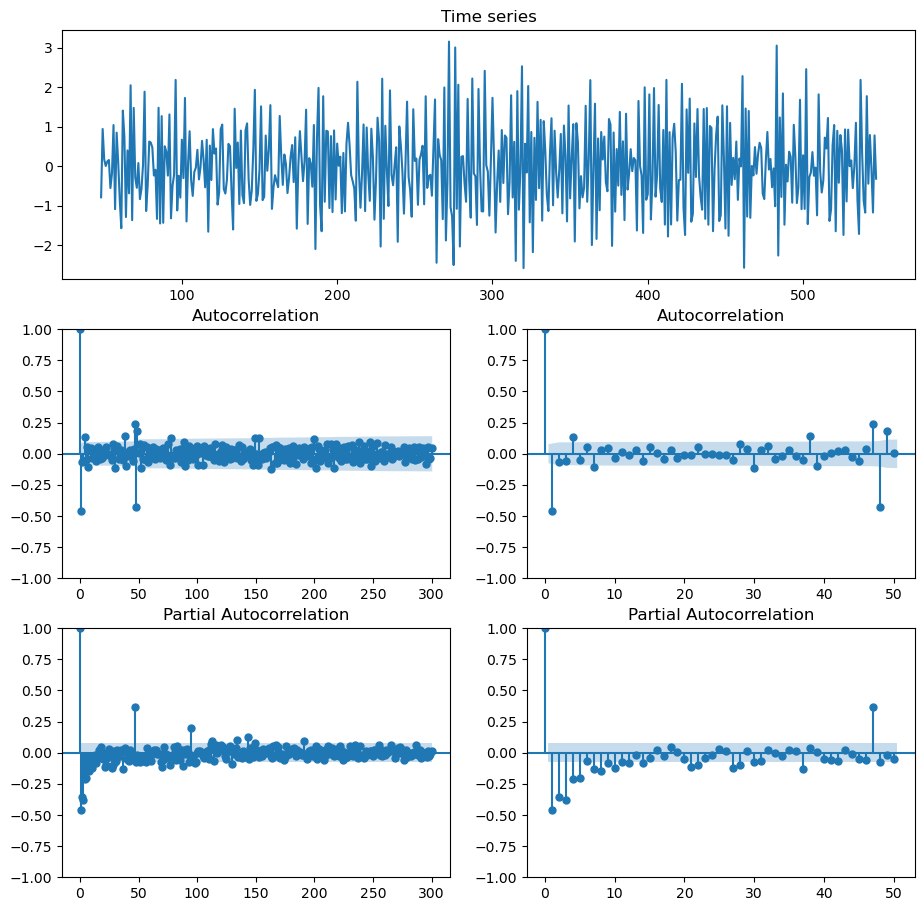

In [6]:
fig, axs = plt.subplots(3, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(ts_diff[:500])
axbig.set_title('Time series')

smt.graphics.plot_acf(ts_diff, lags=300, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(ts_diff, lags=300, ax=axs[2,0], alpha=0.05)

smt.graphics.plot_acf(ts_diff, lags=50, ax=axs[1,1], alpha=0.05)
smt.graphics.plot_pacf(ts_diff, lags=50, ax=axs[2,1], alpha=0.05)
plt.show()

Выводы:
1. p = 4.
2. q = 9.

In [12]:
# order=(p, d, q),
# seasonal_order=(P, D, Q, S)
model = SARIMAX(ts, order=(4, 1, 9), seasonal_order=(3, 1, 1, 48))

results = model.fit()

results.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87065D-01    |proj g|=  3.96312D-01

At iterate    5    f=  8.51120D-01    |proj g|=  1.48647D-02

At iterate   10    f=  8.45248D-01    |proj g|=  3.18822D-02

At iterate   15    f=  8.35022D-01    |proj g|=  1.55890D-02

At iterate   20    f=  8.34603D-01    |proj g|=  5.24062D-03

At iterate   25    f=  8.33448D-01    |proj g|=  2.56584D-02

At iterate   30    f=  8.32631D-01    |proj g|=  5.77565D-03

At iterate   35    f=  8.32550D-01    |proj g|=  1.72138D-03

At iterate   40    f=  8.32508D-01    |proj g|=  9.12111D-03

At iterate   45    f=  8.32179D-01    |proj g|=  1.29030D-02

At iterate   50    f=  8.32059D-01    |proj g|=  2.08209D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/bogdanovaleksandr/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  700
Model:             SARIMAX(4, 1, 9)x(3, 1, [1], 48)   Log Likelihood                -582.441
Date:                              Tue, 24 Oct 2023   AIC                           1200.883
Time:                                      17:26:34   BIC                           1281.496
Sample:                                           0   HQIC                          1232.148
                                              - 700                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5960      0.431     -1.383      0.167      -1.440       0.248
ar.L2         -0.0380      0.271     -0.140      0.888      -0.568       0.492
ar.L3          0.4424      0.235      1.880      0.060      -0.019       0.904
ar.L4          0.6300      0.296      2.127      0.033       0.049       1.211
ma.L1         -0.2409      0.436     -0.553      0.580      -1.094       0.613
ma.L2         -0.4383      0.376     -1.165      0.244      -1.176       0.299
ma.L3         -0.5245      0.260     -2.016      0.044      -1.034      -0.015
ma.L4         -0.2701      0.402     -0.672      0.501      -1.058       0.517
ma.L5          0.5590      0.251      2.226      0.026       0.067       1.051
ma.L6          0.0682      0.055      1.239      0.215      -0.040       0.176
ma.L7          0.0014      0.067      0.021      0.983      -0.129       0.132
ma.L8         -0.1014      0.049     -2.087      0.037      -0.197      -0.006
ma.L9          0.0090      0.062      0.146      0.884      -0.112       0.130
ar.S.L48      -0.0254      0.101     -0.252      0.801      -0.223       0.172
ar.S.L96      -0.0258      0.081     -0.318      0.750      -0.184       0.133
ar.S.L144     -0.0055      0.065     -0.085      0.933      -0.134       0.123
ma.S.L48      -0.7441      0.104     -7.142      0.000      -0.948      -0.540
sigma2         0.3281      0.018     17.804      0.000       0.292       0.364
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 4.42
Prob(Q):                              0.81   Prob(JB):                         0.11
Heteroskedasticity (H):               1.16   Skew:                             0.19
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model1 = pm.auto_arima(
    y = ts,
    seasonal=True,
    m=48,
    start_p = 1, max_p = 9,
    start_d = 1, max_d = 1,
    start_q = 2, max_q = 11,
    start_P = 1, max_P = 5,
    start_D = 1, max_D = 1,
    start_Q = 1, max_Q = 3,
    # trace=True,
    error_action='ignore',
    # suppress_warnings=True
)

print(model1.summary())

# Задание
- Выбрать один из временных рядов из списка.(или любой другой временной ряд который вы захотите - главное, чтобы он не был слишком простым)
- Визуализировать ACF и PACF.
- Построить и выбрать лучшую AR, ARMA, SARIMA модели.(для последней можно использовать auto arima)
- К лучшей модели из предыдущих попробовать добавить GARCH.
- Проанализирвоать результаты работы моделей (Анализ ошибки) для каждой из моделей
  - Графики остатков + выводы
  - Распределение остатков + выводы

##### Выбрать один из временных рядов из списка

Я взял первый датасет.

In [7]:
DATA_PATH = "https://raw.githubusercontent.com/intsystems/MathematicalForecastingMethods/main/data/AirPassengers.csv"

In [8]:
ts = pd.read_csv(DATA_PATH, index_col=[0], parse_dates=['Month'])

Разделим данные на обучающую и тестовую выборку.

In [9]:
train = ts.iloc[:int(0.75 * ts.shape[0])]
test = ts.iloc[int(0.75 * ts.shape[0]):]

Построим график временного ряда

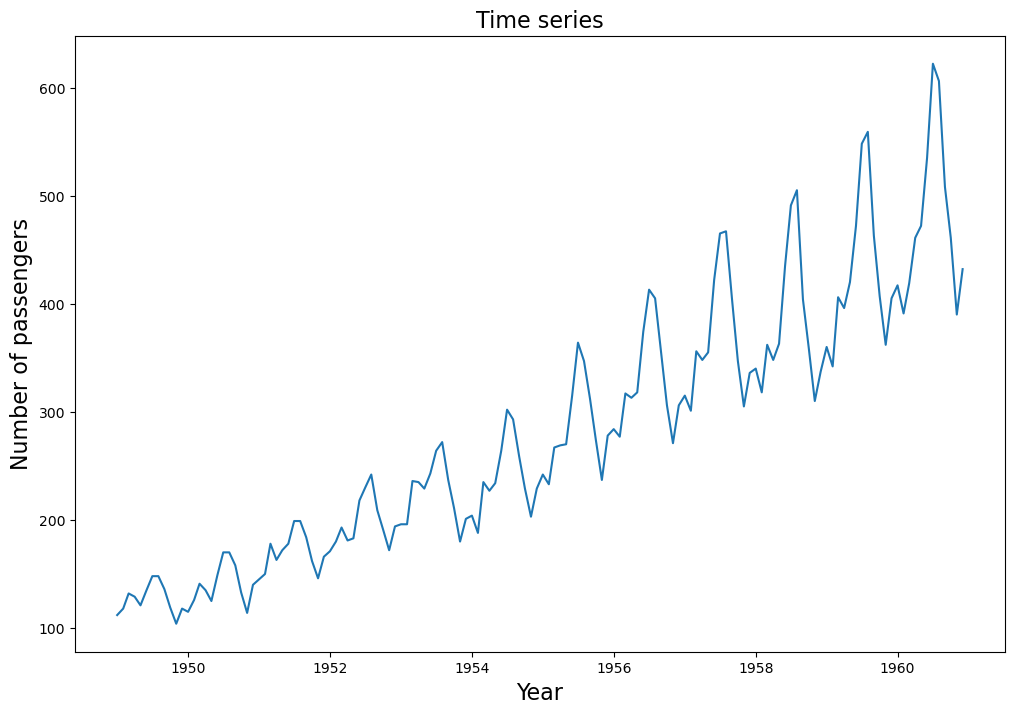

In [10]:
plt.figure(figsize = (12, 8))
plt.plot(ts)
plt.title('Time series', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of passengers', fontsize=16)
plt.show()

Из графика видно, что длина сезона - S = 12 месяцев.

##### Визуализировать ACF и PACF

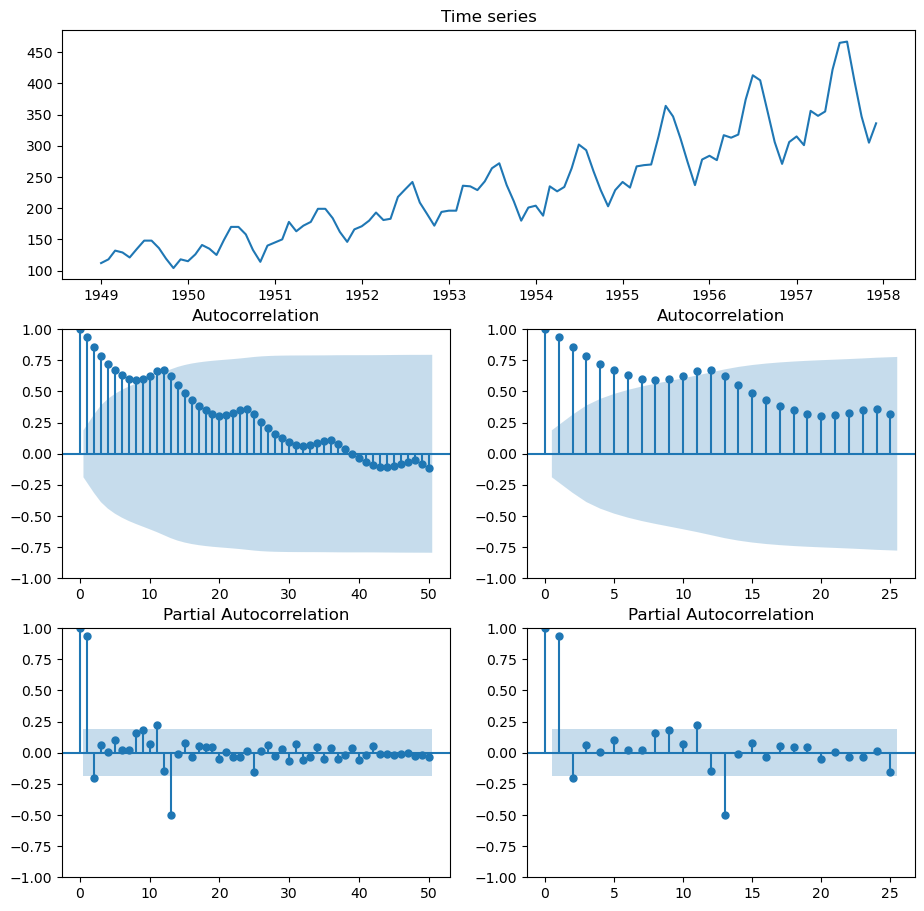

In [11]:
fig, axs = plt.subplots(3, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(train)
axbig.set_title('Time series')

smt.graphics.plot_acf(train, lags=50, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(train, lags=50, ax=axs[2,0], alpha=0.05)

smt.graphics.plot_acf(train, lags=25, ax=axs[1,1], alpha=0.05)
smt.graphics.plot_pacf(train, lags=25, ax=axs[2,1], alpha=0.05)
plt.show()

Сезонный порядок Q = 1, P = 3.

Определим порядок дифференцирования.

In [12]:
ts_diff = train['#Passengers'].diff(periods=12).diff(periods=12)
ts_diff = ts_diff.dropna()
ts_diff = np.diff(ts_diff, n = 2)

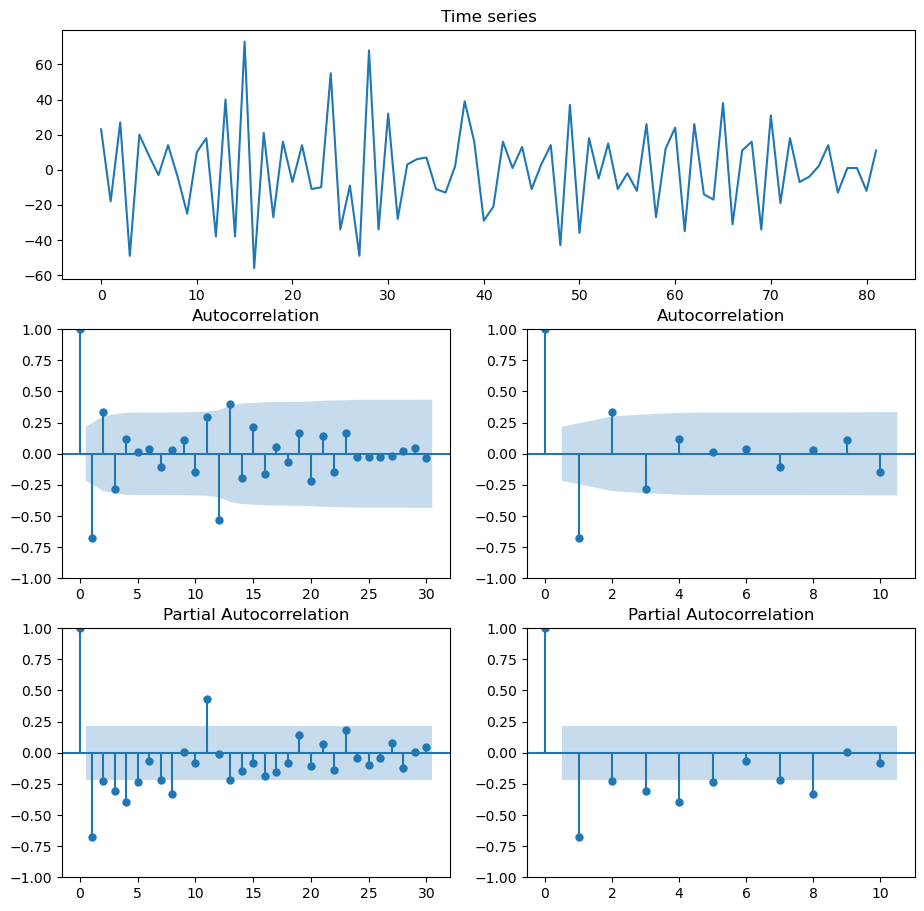

In [13]:
fig, axs = plt.subplots(3, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(ts_diff[:500])
axbig.set_title('Time series')

smt.graphics.plot_acf(ts_diff, lags=30, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(ts_diff, lags=30, ax=axs[2,0], alpha=0.05)

smt.graphics.plot_acf(ts_diff, lags=10, ax=axs[1,1], alpha=0.05)
smt.graphics.plot_pacf(ts_diff, lags=10, ax=axs[2,1], alpha=0.05)
plt.show()

Дифференцирование d = 2, D = 2.

p = 1.

q = 1.

##### Построить и выбрать лучшую AR, ARMA, SARIMA модели

Параметры:

In [14]:
p = 1
d = 2
q = 1
P = 3
D = 2
Q = 1
S = 12

###### AR(p)

In [15]:
model = SARIMAX(train, order=(p, 0, 0))
result = model.fit(disp=False)

/Users/bogdanovaleksandr/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/bogdanovaleksandr/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/bogdanovaleksandr/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [16]:
prediction_train = result.get_prediction(train.index[0], train.index[-1]).summary_frame()
prediction_test = result.get_prediction(test.index[0], test.index[-1]).summary_frame()

print(f"MSE on train = {mean_squared_error(train['#Passengers'], prediction_train['mean']):.3f}")
print(f"MSE on test = {mean_squared_error(test['#Passengers'], prediction_test['mean']):.3f}")

MSE on train = 780.640
MSE on test = 23197.772


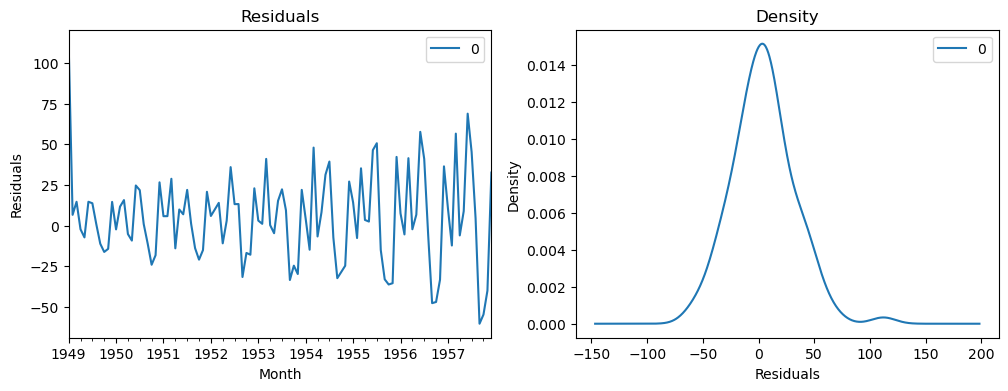

In [17]:
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
residuals.plot(title="Residuals", ax=ax[0])
ax[0].set_ylabel('Residuals')
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].set_xlabel('Residuals')
plt.show()

Дисперсия со временем увеличивается. Распределение приблизительно нормальное.

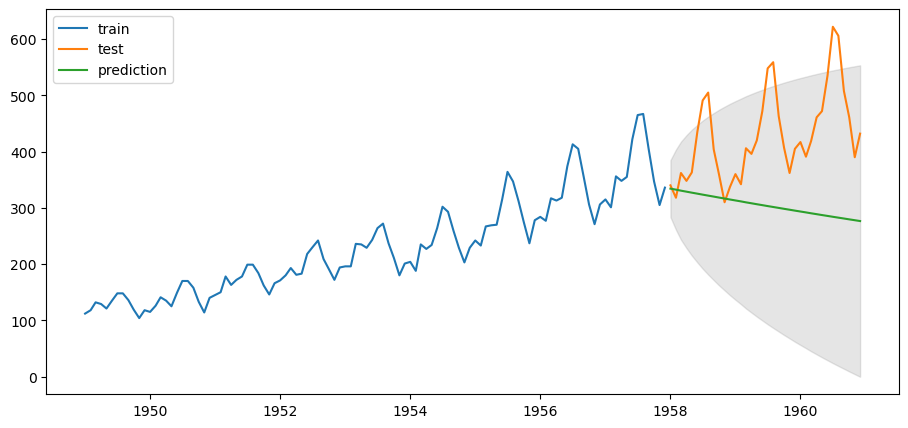

In [18]:
fc = result.get_forecast(len(test)).summary_frame()
plt.figure(figsize=(11, 5))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(fc['mean'], label='prediction')
plt.fill_between(fc.index, fc['mean_ci_lower'], fc['mean_ci_upper'], color='grey', alpha=0.2)
plt.legend()
plt.show()

Модель не предсказывает.

###### ARMA(p, q)

In [19]:
model = SARIMAX(train, order=(p, 0, q))
result = model.fit(disp=False)

/Users/bogdanovaleksandr/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/bogdanovaleksandr/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [20]:
prediction_train = result.get_prediction(train.index[0], train.index[-1]).summary_frame()
prediction_test = result.get_prediction(test.index[0], test.index[-1]).summary_frame()

print(f"MSE on train = {mean_squared_error(train['#Passengers'], prediction_train['mean']):.3f}")
print(f"MSE on test = {mean_squared_error(test['#Passengers'], prediction_test['mean']):.3f}")

MSE on train = 700.269
MSE on test = 25705.952


MSE на тестовой выборке стала хуже.

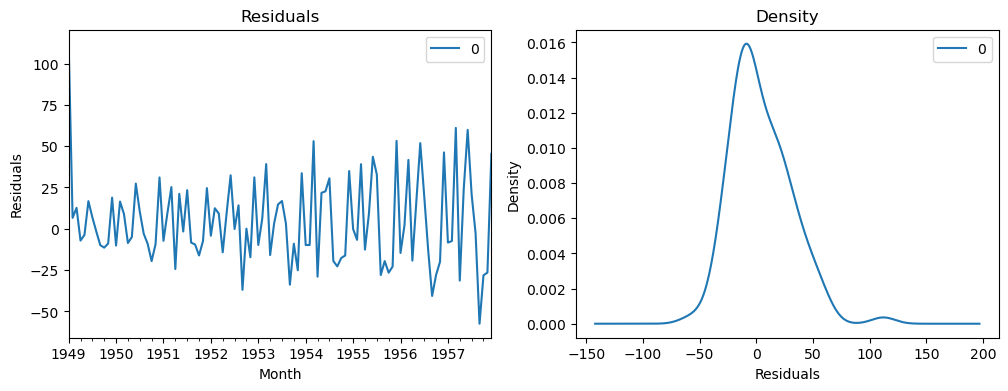

In [21]:
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
residuals.plot(title="Residuals", ax=ax[0])
ax[0].set_ylabel('Residuals')
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].set_xlabel('Residuals')
plt.show()

Дисперсия со временем увеличивается. Распределение приблизительно нормальное.

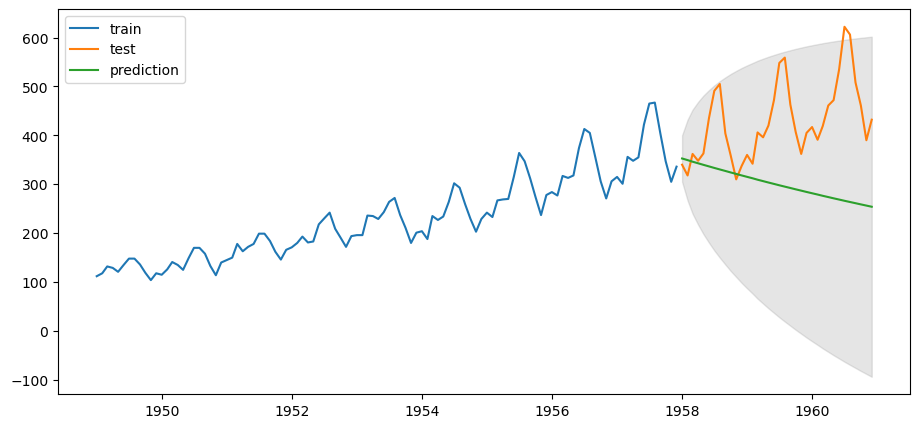

In [22]:
fc = result.get_forecast(len(test)).summary_frame()
plt.figure(figsize=(11, 5))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(fc['mean'], label='prediction')
plt.fill_between(fc.index, fc['mean_ci_lower'], fc['mean_ci_upper'], color='grey', alpha=0.2)
plt.legend()
plt.show()

###### SARIMA(p, d, q)(P, D, Q)_S

In [23]:
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S))
result = model.fit(disp=False)

/Users/bogdanovaleksandr/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/bogdanovaleksandr/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/bogdanovaleksandr/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
prediction_train = result.get_prediction(train.index[0], train.index[-1]).summary_frame()
prediction_test = result.get_prediction(test.index[0], test.index[-1]).summary_frame()

print(f"MSE on train = {mean_squared_error(train['#Passengers'], prediction_train['mean']):.3f}")
print(f"MSE on test = {mean_squared_error(test['#Passengers'], prediction_test['mean']):.3f}")

MSE on train = 409.847
MSE on test = 330.725


MSE стала хорошей.

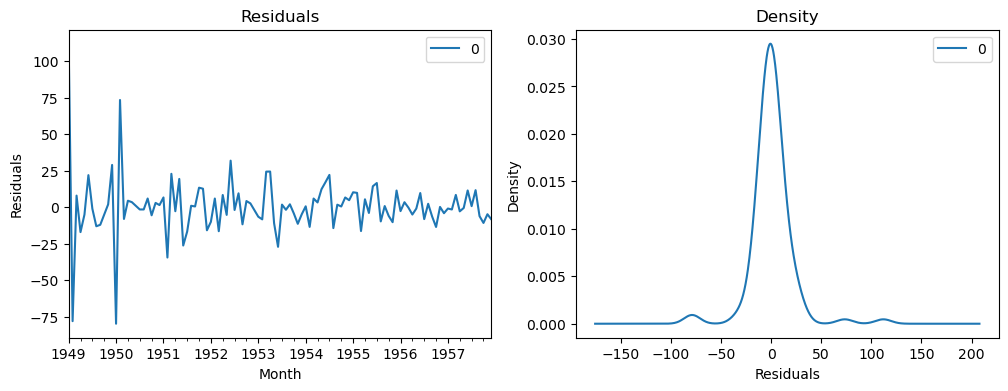

In [25]:
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
residuals.plot(title="Residuals", ax=ax[0])
ax[0].set_ylabel('Residuals')
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].set_xlabel('Residuals')
plt.show()

Дисперсия не очень большая и приблизительно постоянная, распределение нормальное. Есть парочка выбросов. 

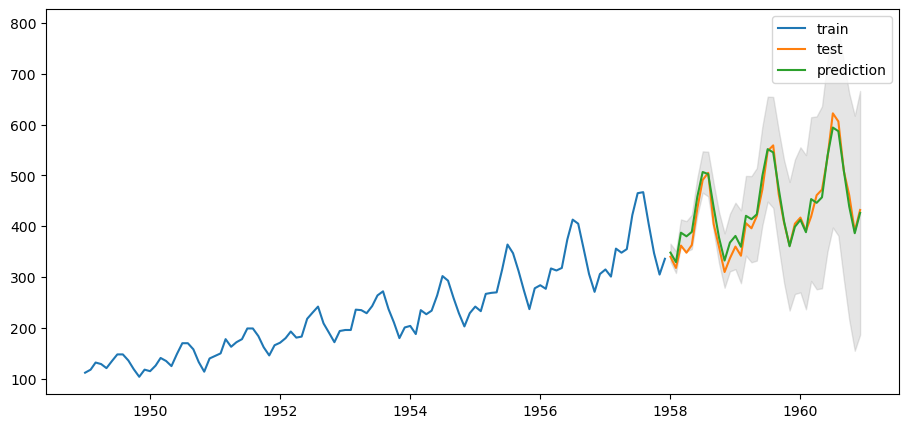

In [26]:
fc = result.get_forecast(len(test)).summary_frame()
plt.figure(figsize=(11, 5))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(fc['mean'], label='prediction')
plt.fill_between(fc.index, fc['mean_ci_lower'], fc['mean_ci_upper'], color='grey', alpha=0.2)
plt.legend()
plt.show()

##### К лучшей модели из предыдущих попробовать добавить GARCH

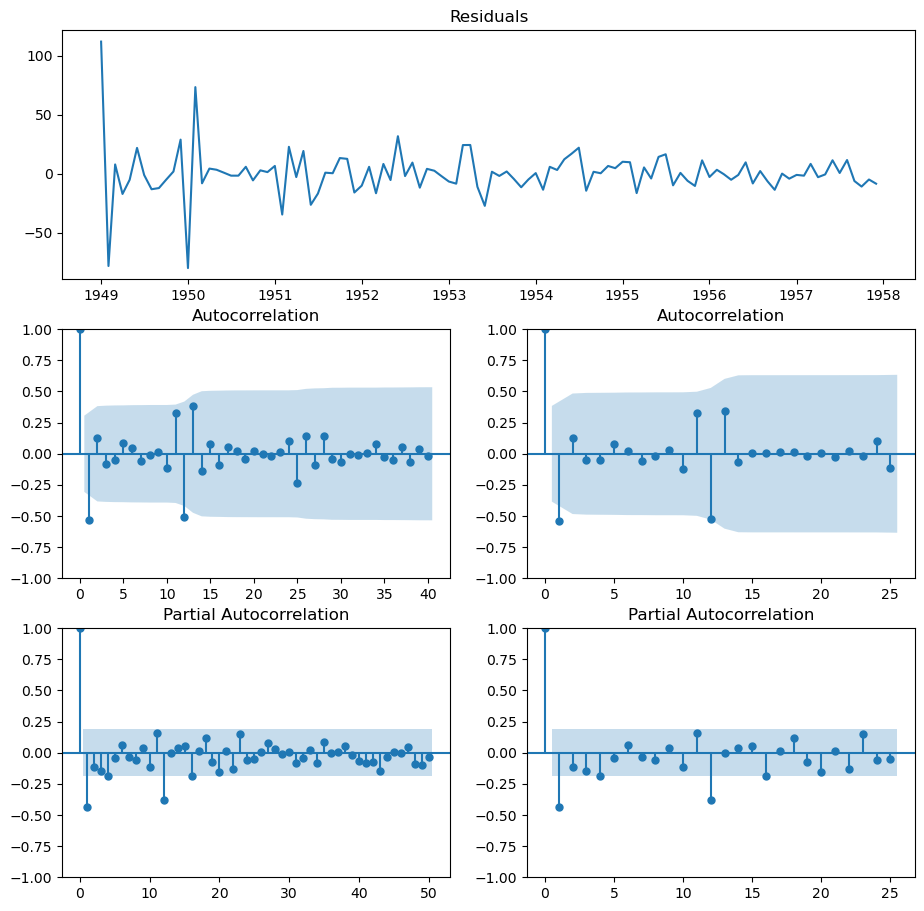

In [27]:
fig, axs = plt.subplots(3, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(result.resid)
axbig.set_title('Residuals')

smt.graphics.plot_acf(result.resid[:41], lags=40, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(result.resid, lags=50, ax=axs[2,0], alpha=0.05)

smt.graphics.plot_acf(result.resid[:26], lags=25, ax=axs[1,1], alpha=0.05)
smt.graphics.plot_pacf(result.resid, lags=25, ax=axs[2,1], alpha=0.05)
plt.show()

p = 1.

q = 2.

In [29]:
model_garch = arch_model(result.resid, p=1, q=2, vol="GARCH")
result_garch = model_garch.fit(disp=False)

In [30]:
residuals_mean = result_garch.forecast(horizon=len(test)).mean.iloc[-1].values
print(residuals_mean)

[0.21427769 0.21427769 0.21427769 0.21427769 0.21427769 0.21427769
 0.21427769 0.21427769 0.21427769 0.21427769 0.21427769 0.21427769
 0.21427769 0.21427769 0.21427769 0.21427769 0.21427769 0.21427769
 0.21427769 0.21427769 0.21427769 0.21427769 0.21427769 0.21427769
 0.21427769 0.21427769 0.21427769 0.21427769 0.21427769 0.21427769
 0.21427769 0.21427769 0.21427769 0.21427769 0.21427769 0.21427769]


Дисперсия практически постоянная, к тому же мы видим, что среднее значение мало по сравнению с величиной, поэтому нет смысла использовать GARCH.